In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os
import typing
import warnings

from downstream import dstream
from IPython.display import display
import more_itertools as mit
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp
from tqdm.auto import tqdm


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-20T20:35:27.081279+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1030-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot       : 1.4.2
downstream    : 1.11.0
more_itertools: 9.1.0
numpy         : 2.1.2
polars        : 1.9.0
pandas        : 2.2.3
seaborn       : 0.13.2

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = False
teeplot_subdir = os.environ.get("NOTEBOOK_NAME", "2025-07-19-mem-perf-tilted")
teeplot_subdir


'2025-07-19-mem-perf-tilted'

## Calc comparator capacities


In [5]:
algo_names = {
    # "dstream.circular_algo": "simple ringbuf",
    # "control_throwaway_algo": "no-operation",
    "dstream.tilted_algo": "extended ringbuf",
    # "dstream_tilted_algo": "extended ringbuf LUT",
    # "doubling_tilted_algo": "naive doubling",
    # "zhao_tilted_algo": "pyrimidal bucket",
    "zhao_tilted_full_algo": "saturating bucket",
}


df = pl.concat(
    [
        pl.read_csv("https://osf.io/cbqpx/download"),
    ],
)
print("\n".join(df["algo_name"].unique().to_list()))
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .filter(
        pl.col("algo_name").is_in(
            algo_names.keys(),
        ),
        pl.col("num_items") == 1_000_000,
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            algo_names.__getitem__,
            return_dtype=str,
        ),
        num_retained=(
            pl.when(pl.col("algo_name") == "dstream_tilted_algo")
            .then(pl.col("num_sites"))
            .when(pl.col("algo_name") == "doubling_tilted_algo")
            .then(pl.col("num_sites") * 0.75)
            .when(pl.col("algo_name") == "zhao_tilted_algo")
            .then(19)
            .when(pl.col("algo_name") == "zhao_tilted_full_algo")
            .then(pl.col("num_sites"))
            .otherwise(pl.col("num_sites"))
        ),
    )
    .with_columns(
        (pl.col("memory_bytes") / pl.col("num_retained")).alias(
            "bytes per item"
        ),
    )
    .with_columns(
        (8 * pl.col("memory_bytes") / pl.col("num_retained")).alias(
            "bits per item"
        ),
    )
    .with_columns(
        memory_bits=pl.col("memory_bytes") * 8,
        item_bits=(
            pl.col("data_type").map_elements(
                {"bit": 1, "byte": 8, "word": 16, "double word": 32}.get,
                return_dtype=pl.Int32,
            )
        ),
    )
    .with_columns(
        overhead_bits=(
            pl.col("memory_bits")
            - pl.col("item_bits") * pl.col("num_retained")
        ),
    )
    .with_columns(overhead_bytes=pl.col("overhead_bits") // 8)
    .with_columns(
        (100 * pl.col("item_bits") / pl.col("bits per item")).alias(
            "Memory Efficiency (%)"
        ),
    )
    .with_columns(pl.col("data_type").alias("data type"))
    .filter(pl.col("replicate") == 0)
)

display(df.describe()), display(df.head()), display(df.tail());


dstream.steady_algo
dstream.compressing_algo
zhao_tilted_full_algo
doubling_tilted_algo
control_throwaway_algo
dstream_tilted_algo
dstream.circular_algo
doubling_steady_algo
zhao_tilted_algo
dstream.tilted_algo
dstream_stretched_algo
zhao_steady_algo
dstream.stretched_algo


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""32""","""32""","""32""",32.0,32.0,32.0,32.0,32.0,"""32""",32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,"""32"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,null,2480.5,1e6,1360.0,0.0,18.30623,null,1360.0,1.998657,15.989258,19844.0,14.25,464.0,58.0,84.553419,null
"""std""",null,null,null,4271.671094,0.0,1645.87649,0.0,42.149057,null,1645.87649,1.504448,12.035587,34173.368752,11.725352,466.918519,58.364815,23.199722,null
"""min""","""dstream.tilted_algo""","""bit""","""g++""",12.0,1e6,64.0,0.0,1.253929,"""extended ringbuf""",64.0,0.125977,1.0078125,96.0,1.0,32.0,4.0,11.111111,"""bit"""
"""25%""",null,null,null,192.0,1e6,256.0,0.0,2.236256,null,256.0,1.003906,8.03125,1536.0,8.0,32.0,4.0,80.0,null
"""50%""",null,null,null,640.0,1e6,1024.0,0.0,2.316201,null,1024.0,2.000977,16.007812,5120.0,16.0,512.0,64.0,96.969697,null
"""75%""",null,null,null,2176.0,1e6,1024.0,0.0,8.671135,null,1024.0,3.0,24.0,17408.0,16.0,1024.0,128.0,99.224806,null
"""max""","""zhao_tilted_full_algo""","""word""","""g++""",16512.0,1e6,4096.0,0.0,204.034473,"""saturating bucket""",4096.0,5.0,40.0,132096.0,32.0,1024.0,128.0,99.975592,"""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,i32,i32,f64,f64,f64,str
"""dstream.tilted_algo""","""double word""","""g++""",16388,1000000,4096,0,2.3119,"""extended ringbuf""",4096.0,4.000977,32.007812,131104,32,32.0,4.0,99.975592,"""double word"""
"""dstream.tilted_algo""","""double word""","""g++""",4100,1000000,1024,0,2.293708,"""extended ringbuf""",1024.0,4.003906,32.03125,32800,32,32.0,4.0,99.902439,"""double word"""
"""dstream.tilted_algo""","""double word""","""g++""",1028,1000000,256,0,2.236288,"""extended ringbuf""",256.0,4.015625,32.125,8224,32,32.0,4.0,99.610895,"""double word"""
"""dstream.tilted_algo""","""double word""","""g++""",260,1000000,64,0,1.890558,"""extended ringbuf""",64.0,4.0625,32.5,2080,32,32.0,4.0,98.461538,"""double word"""
"""dstream.tilted_algo""","""word""","""g++""",8196,1000000,4096,0,2.311717,"""extended ringbuf""",4096.0,2.000977,16.007812,65568,16,32.0,4.0,99.951196,"""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,algorithm,num_retained,bytes per item,bits per item,memory_bits,item_bits,overhead_bits,overhead_bytes,Memory Efficiency (%),data type
str,str,str,i32,i32,i32,i32,f64,str,f64,f64,f64,i32,i32,f64,f64,f64,str
"""zhao_tilted_full_algo""","""byte""","""g++""",128,1000000,64,0,1.253929,"""saturating bucket""",64.0,2.0,16.0,1024,8,512.0,64.0,50.0,"""byte"""
"""zhao_tilted_full_algo""","""bit""","""g++""",640,1000000,4096,0,204.034473,"""saturating bucket""",4096.0,0.15625,1.25,5120,1,1024.0,128.0,80.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",256,1000000,1024,0,42.078388,"""saturating bucket""",1024.0,0.25,2.0,2048,1,1024.0,128.0,50.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",160,1000000,256,0,9.695824,"""saturating bucket""",256.0,0.625,5.0,1280,1,1024.0,128.0,20.0,"""bit"""
"""zhao_tilted_full_algo""","""bit""","""g++""",72,1000000,64,0,3.017432,"""saturating bucket""",64.0,1.125,9.0,576,1,512.0,64.0,11.111111,"""bit"""


In [6]:
records = []
for (data_type, item_bits, num_sites,), group in df.to_pandas().groupby(
    ["data_type", "item_bits", "num_sites"],
):
    assert len(group) == 2
    tilted_memory_bits = group.loc[
        group["algorithm"] == "extended ringbuf", "memory_bits"
    ].item()
    zhao_memory_bits = group.loc[
        group["algorithm"] == "saturating bucket", "memory_bits"
    ].item()

    assert tilted_memory_bits < zhao_memory_bits
    zhao_capacity = (
        num_sites - (zhao_memory_bits - tilted_memory_bits) // item_bits
    )

    records.append(
        {
            "data_type": data_type,
            "num_sites": num_sites,
            "item_bits": item_bits,
            "tilted_memory_bits": tilted_memory_bits,
            "ringbuf_capacity": num_sites,
            "zhao_memory_bits": zhao_memory_bits,
            "zhao_capacity": zhao_capacity,
        }
    )

sizes_df = pd.DataFrame.from_records(records)
sizes_df


,data_type,num_sites,item_bits,tilted_memory_bits,ringbuf_capacity,zhao_memory_bits,zhao_capacity
0,bit,64,1,96,64,576,-416
1,bit,256,1,288,256,1280,-736
2,bit,1024,1,1056,1024,2048,32
3,bit,4096,1,4128,4096,5120,3104
4,byte,64,8,544,64,1024,4
5,byte,256,8,2080,256,3072,132
6,byte,1024,8,8224,1024,9216,900
7,byte,4096,8,32800,4096,33792,3972
8,double word,64,32,2080,64,2560,49
9,double word,256,32,8224,256,9216,225


## Define


In [7]:
def calc_max_qos_from_segment_lengths(segment_lengths: list[int]) -> float:
    segment_total = sum(segment_lengths)
    return max(
        (segment_length - 1)
        / (segment_total - cumulative - segment_length + 1 or 1)
        for cumulative, segment_length in zip(
            it.accumulate([0, *segment_lengths]),
            [*segment_lengths, 1],
        )
    )


In [8]:
def calc_mean_qos_from_segment_lengths(segment_lengths: list[int]) -> float:
    segment_total = sum(segment_lengths)
    segment_fenceposts = it.accumulate([0, *segment_lengths])
    values = []
    for begin, end in it.pairwise(segment_fenceposts):
        for rank in range(begin, end):
            depth = segment_total - rank
            assert depth
            values.append((end - begin - 1) / depth)

    values.append(0)  # fencepost

    assert len(values) == segment_total + 1
    assert max(values) == calc_max_qos_from_segment_lengths(segment_lengths)
    return np.mean(values)


In [9]:
def calc_max_gaps_dstream(
    buffer_size: int,
    num_items: int,
    calc_qos: typing.Callable,
) -> list[int]:
    inventories = dstream.tilted_algo.lookup_ingest_times_batched(
        buffer_size,
        np.arange(buffer_size, num_items),
    ).astype(np.int64)
    sorted_inventories = np.sort(
        inventories,
        axis=1,
    )
    gaps = np.diff(sorted_inventories, axis=1)
    return [0] * buffer_size + [calc_qos(gap_lengths) for gap_lengths in gaps]


In [10]:
def calc_max_gaps_zhao_tilted_full(
    buffer_size: int,
    num_items: int,
    calc_qos: typing.Callable,
) -> list[int]:
    bucket_sizes = [buffer_size, 0]
    buffer = [*range(buffer_size)]
    max_gaps = [0]

    S = buffer_size
    w = bucket_sizes
    for k in tqdm(range(num_items), leave=False):
        if k < S:
            assert buffer[k] == k
        else:
            bucket_sizes[0] += 1
            i = S
            j = 0
            while w[j] <= w[j + 1]:
                i -= w[j]
                j += 1
                if j == len(w) - 1:
                    w.append(0)

            assert 0 <= i <= S
            w[j] -= 2
            w[j + 1] += 1
            for n in range(i - w[j], S - 1):
                assert 0 < n < S - 1
                buffer[n] = buffer[n + 1]
            buffer[S - 1] = k

        assert buffer == sorted(buffer)
        assert sum(bucket_sizes) == buffer_size

        segment_lengths = [b - a for a, b in mit.pairwise(sorted(buffer))]
        assert (
            sum(segment_lengths)
            == buffer_size + max(k - buffer_size + 1, 0) - 1
        )
        max_gaps.append(
            calc_qos(segment_lengths),
        )

    return max_gaps[:-1]


## Example Plot


In [11]:
qos_num_items = 10_000


def make_df(buffer_size_ringbuf: int, buffer_size_zhao: int) -> pl.DataFrame:
    return pl.concat(
        [
            pl.DataFrame(
                {
                    "Algorithm": "extended ringbuf",
                    "Gap Size Cost": np.mean(
                        calc_max_gaps_dstream(
                            buffer_size_ringbuf,
                            qos_num_items,
                            calc_max_qos_from_segment_lengths,
                        )
                    ),
                    "Gap Size Cost Mean": np.mean(
                        calc_max_gaps_dstream(
                            buffer_size_ringbuf,
                            qos_num_items,
                            calc_mean_qos_from_segment_lengths,
                        )
                    ),
                    "Num Items Ingested": qos_num_items,
                },
                strict=False,
            ),
            pl.DataFrame(
                {
                    "Algorithm": "saturating bucket",
                    "Gap Size Cost": np.mean(
                        calc_max_gaps_zhao_tilted_full(
                            buffer_size_zhao,
                            qos_num_items,
                            calc_max_qos_from_segment_lengths,
                        )
                    )
                    if buffer_size_zhao > 1
                    else np.inf,
                    "Gap Size Cost Mean": np.mean(
                        calc_max_gaps_zhao_tilted_full(
                            buffer_size_zhao,
                            qos_num_items,
                            calc_mean_qos_from_segment_lengths,
                        )
                    )
                    if buffer_size_zhao > 1
                    else np.inf,
                    "Num Items Ingested": qos_num_items,
                },
                strict=False,
            ),
        ],
    )


In [12]:
def _row_to_df(row: dict) -> pl.DataFrame:
    df = make_df(
        buffer_size_ringbuf=row["ringbuf_capacity"],
        buffer_size_zhao=row["zhao_capacity"],
    )
    return df.with_columns(
        data_type=pl.lit(row["data_type"]),
        item_bits=pl.lit(row["item_bits"]),
        num_sites=pl.lit(row["num_sites"]),
        tilted_memory_bits=pl.lit(row["tilted_memory_bits"]),
        zhao_memory_bits=pl.lit(row["zhao_memory_bits"]),
    )


In [13]:
records = sizes_df.to_dict(orient="records")
dfs = [*map(_row_to_df, tqdm(records))]


 92%|█████████▏| 9189/10000 [00:00<00:00, 91881.54it/s]
                                                       
 99%|█████████▉| 9932/10000 [00:08<00:00, 1113.29it/s]
                                                      
  0%|          | 0/10000 [00:00<?, ?it/s]
                                         
 80%|████████  | 8020/10000 [00:00<00:00, 26697.58it/s]
                                                       
 99%|█████████▉| 9916/10000 [00:02<00:00, 4115.37it/s]
                                                      
 99%|█████████▉| 9941/10000 [00:10<00:00, 877.00it/s]
                                                     
 66%|██████▌   | 6577/10000 [00:00<00:00, 65763.63it/s]
                                                       
 97%|█████████▋| 9747/10000 [00:00<00:00, 16195.17it/s]
                                                       
 97%|█████████▋| 9674/10000 [00:02<00:00, 3645.99it/s]
                                                      
 99%|█████████▉| 9936/10000 [0

In [14]:
qos_df = pl.concat(dfs)
qos_df


Algorithm,Gap Size Cost,Gap Size Cost Mean,Num Items Ingested,data_type,item_bits,num_sites,tilted_memory_bits,zhao_memory_bits
str,f64,f64,i64,str,i32,i32,i32,i32
"""extended ringbuf""",0.236231,0.140289,10000,"""bit""",1,64,96,576
"""saturating bucket""",inf,inf,10000,"""bit""",1,64,96,576
"""extended ringbuf""",0.046194,0.024004,10000,"""bit""",1,256,288,1280
"""saturating bucket""",inf,inf,10000,"""bit""",1,256,288,1280
"""extended ringbuf""",0.006272,0.003273,10000,"""bit""",1,1024,1056,2048
…,…,…,…,…,…,…,…,…
"""saturating bucket""",0.036892,0.025326,10000,"""word""",16,256,4128,5120
"""extended ringbuf""",0.006272,0.003273,10000,"""word""",16,1024,16416,17408
"""saturating bucket""",0.004156,0.002696,10000,"""word""",16,1024,16416,17408


In [15]:
qos_long_df = (
    qos_df.unpivot(
        index=[
            "data_type",
            "item_bits",
            "num_sites",
            "Algorithm",
            "tilted_memory_bits",
        ],
        on=["Gap Size Cost", "Gap Size Cost Mean"],
        variable_name="metric",
        value_name="value",
    )
    .pivot(
        values="value",
        index=[
            "data_type",
            "item_bits",
            "num_sites",
            "metric",
            "tilted_memory_bits",
        ],
        on="Algorithm",
    )
    .with_columns(tilted_memory_bytes=pl.col("tilted_memory_bits") // 8)
    .with_columns(
        (
            100
            * (
                pl.col("saturating bucket").log()
                - pl.col("extended ringbuf").log()
            )
        )
        .replace(np.nan, np.inf)
        .alias("sympct")
    )
    .with_columns(
        (
            100
            * (pl.col("saturating bucket") - pl.col("extended ringbuf"))
            / (pl.col("extended ringbuf") + pl.col("saturating bucket"))
        )
        .replace(np.inf, 100)
        .replace(np.nan, 100)
        .alias("symetricized")
    )
    .with_columns(
        (
            100
            * (pl.col("saturating bucket") - pl.col("extended ringbuf"))
            / pl.col("extended ringbuf").abs()
        )
        .replace(np.nan, np.inf)
        .alias("percent")
    )
)
qos_long_df


data_type,item_bits,num_sites,metric,tilted_memory_bits,extended ringbuf,saturating bucket,tilted_memory_bytes,sympct,symetricized,percent
str,i32,i32,str,i32,f64,f64,i32,f64,f64,f64
"""bit""",1,64,"""Gap Size Cost""",96,0.236231,inf,12,inf,100.0,inf
"""bit""",1,256,"""Gap Size Cost""",288,0.046194,inf,36,inf,100.0,inf
"""bit""",1,1024,"""Gap Size Cost""",1056,0.006272,0.421014,132,420.663103,97.064436,6612.999965
"""bit""",1,4096,"""Gap Size Cost""",4128,0.000628,0.000562,516,-11.059846,-5.524293,-10.470183
"""byte""",8,64,"""Gap Size Cost""",544,0.236231,350.078762,68,730.110479,99.865132,148093.62494
…,…,…,…,…,…,…,…,…,…,…
"""double word""",32,4096,"""Gap Size Cost Mean""",131104,0.00018,0.000141,16388,-24.251863,-12.066847,-21.535087
"""word""",16,64,"""Gap Size Cost Mean""",1056,0.140289,0.206196,132,38.512186,19.021567,46.979342
"""word""",16,256,"""Gap Size Cost Mean""",4128,0.024004,0.025326,516,5.360819,2.679768,5.507113


## Perf Data


In [16]:
def get_df_perf_long(extended_ringbuf: str) -> pl.DataFrame:
    algo_names = {
        extended_ringbuf: "extended ringbuf",
        # "dstream.circular_algo": "simple ringbuf",
        # "control_throwaway_algo": "no-operation",
        # "dstream.tilted_algo": "extended ringbuf",
        # "dstream_tilted_algo": "extended ringbuf LUT",
        # "doubling_tilted_algo": "naive doubling",
        # "zhao_tilted_algo": "pyrimidal bucket",
        "zhao_tilted_full_algo": "saturating bucket",
    }

    df_perf = pl.concat(
        [
            pl.read_csv("https://osf.io/cbqpx/download").with_columns(
                platform=pl.lit("ARM Cortex-M0+"),
            ),
            pl.read_csv("https://osf.io/ewmk9/download").with_columns(
                platform=pl.lit("ARM Apple M1"),
            ),
            pl.read_csv("https://osf.io/k3vbu/download").with_columns(
                platform=pl.lit("x86 Intel Core Ultra 7 155U"),
            ),
        ],
    )
    df_perf = (
        df_perf.cast(
            {
                "memory_bytes": pl.Int32,
                "num_items": pl.Int32,
                "num_sites": pl.Int32,
                "duration_s": pl.Float64,
                "replicate": pl.Int32,
            },
        )
        .with_columns(
            duration_per_item_ns=(
                pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
            )
        )
        .filter(
            pl.col("algo_name").is_in(
                algo_names.keys(),
            ),
        )
        .filter(
            pl.col("num_items") == 1_000_000,
            pl.col("replicate") == 0,
        )
        .with_columns(
            Algorithm=pl.col("algo_name").map_elements(
                algo_names.__getitem__,
                return_dtype=str,
            ),
            item_bits=pl.col("data_type").map_elements(
                {"bit": 1, "byte": 8, "word": 16, "double word": 32}.get,
                return_dtype=pl.Int32,
            ),
            tilted_memory_bits=pl.col("memory_bytes")
            .min()
            .over(
                pl.col("num_sites"),
                pl.col("data_type"),
                pl.col("platform"),
            )
            * 8,
        )
        .with_columns(pl.col("data_type").alias("data type"))
    )

    return (
        df_perf.unpivot(
            index=[
                "data_type",
                "item_bits",
                "num_sites",
                "Algorithm",
                "tilted_memory_bits",
                "platform",
            ],
            on=["duration_s"],
            variable_name="platformless metric",
            value_name="value",
        )
        .pivot(
            values="value",
            index=[
                "data_type",
                "item_bits",
                "num_sites",
                "platform",
                "platformless metric",
                "tilted_memory_bits",
            ],
            on="Algorithm",
        )
        .with_columns(
            metric=pl.format(
                "{} ({})",
                pl.col("platformless metric"),
                pl.col("platform"),
            ),
        )
        .with_columns(tilted_memory_bytes=pl.col("tilted_memory_bits") // 8)
        .with_columns(
            (
                100
                * (
                    pl.col("saturating bucket").log()
                    - pl.col("extended ringbuf").log()
                )
            ).alias("sympct"),
        )
        .with_columns(
            (
                100
                * (pl.col("saturating bucket") - pl.col("extended ringbuf"))
                / (pl.col("extended ringbuf") + pl.col("saturating bucket"))
            )
            .replace(np.inf, 100)
            .replace(np.nan, 100)
            .alias("symetricized"),
        )
        .with_columns(
            (
                100
                * (pl.col("saturating bucket") - pl.col("extended ringbuf"))
                / pl.col("extended ringbuf").abs()
            )
            .replace(np.nan, np.inf)
            .alias("percent"),
        )
    )


## Plotting


teeplots/2025-07-19-mem-perf-tilted/col=data-type+hue=metric+kind=bar+lut=True+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.pdf
teeplots/2025-07-19-mem-perf-tilted/col=data-type+hue=metric+kind=bar+lut=True+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.png


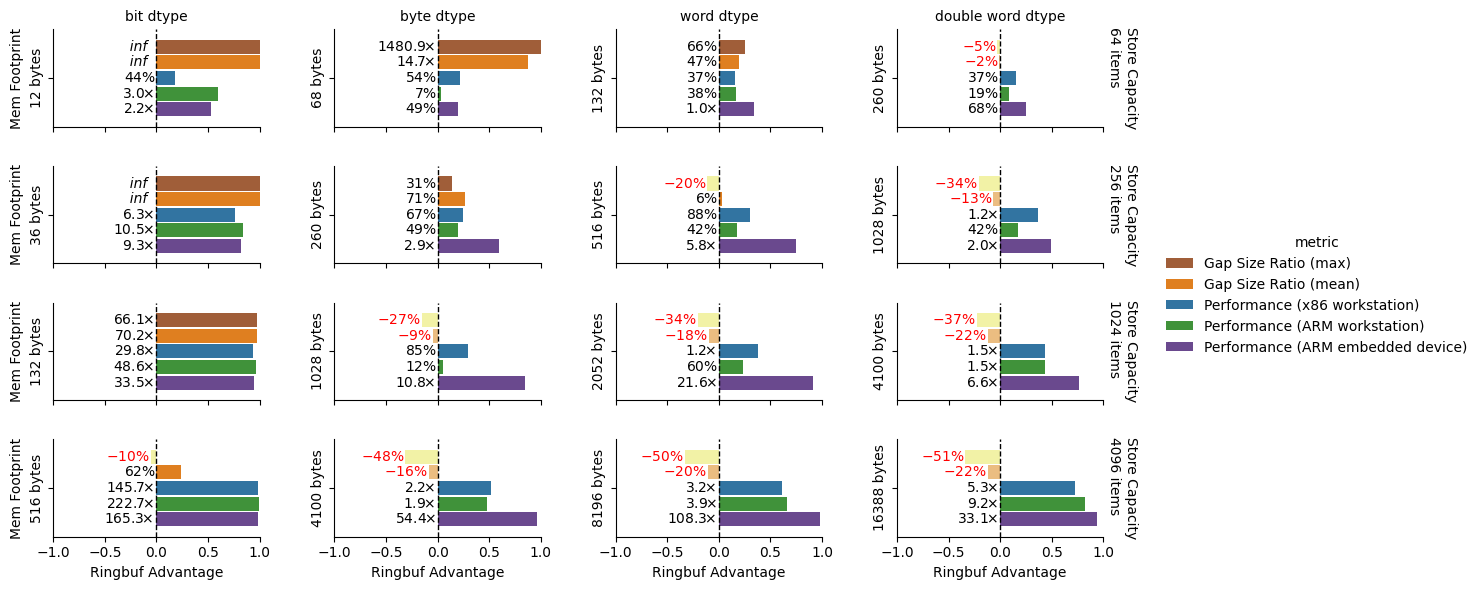

teeplots/2025-07-19-mem-perf-tilted/col=data-type+hue=metric+kind=bar+lut=False+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.pdf
teeplots/2025-07-19-mem-perf-tilted/col=data-type+hue=metric+kind=bar+lut=False+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.png


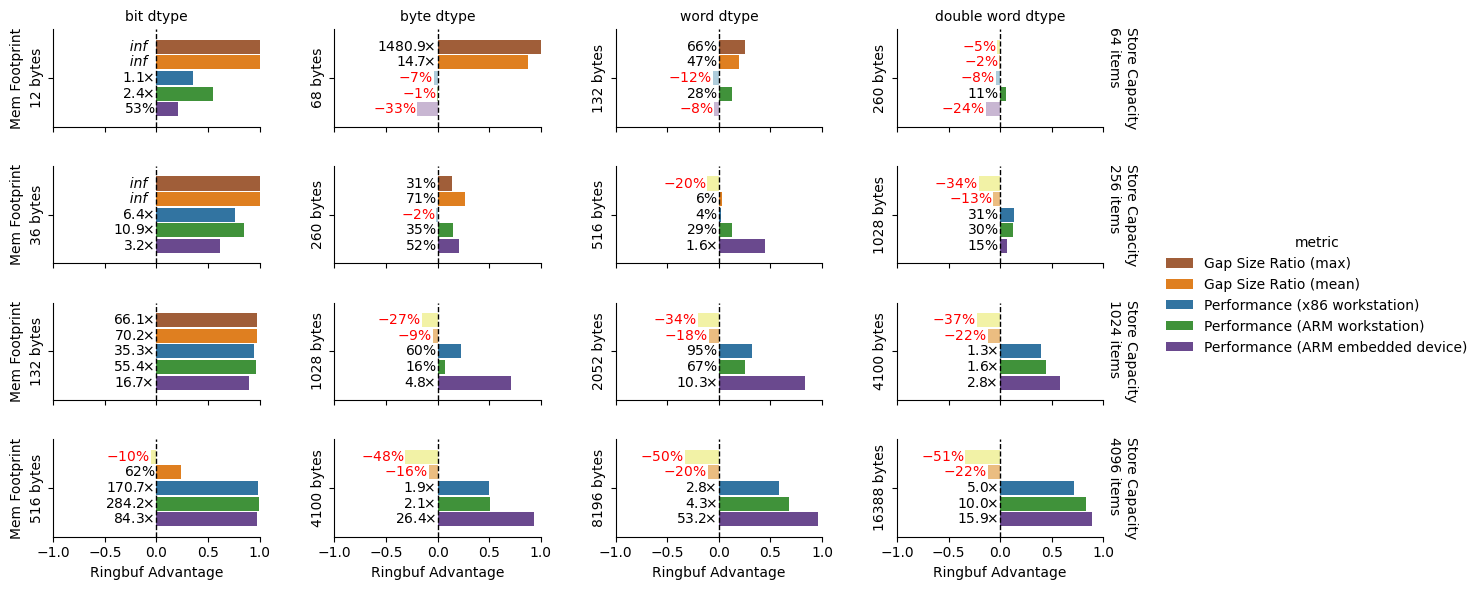

teeplots/2025-07-19-mem-perf-tilted/col=data-type+font.family=serif+hue=metric+kind=bar+lut=True+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.pdf
teeplots/2025-07-19-mem-perf-tilted/col=data-type+font.family=serif+hue=metric+kind=bar+lut=True+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.png


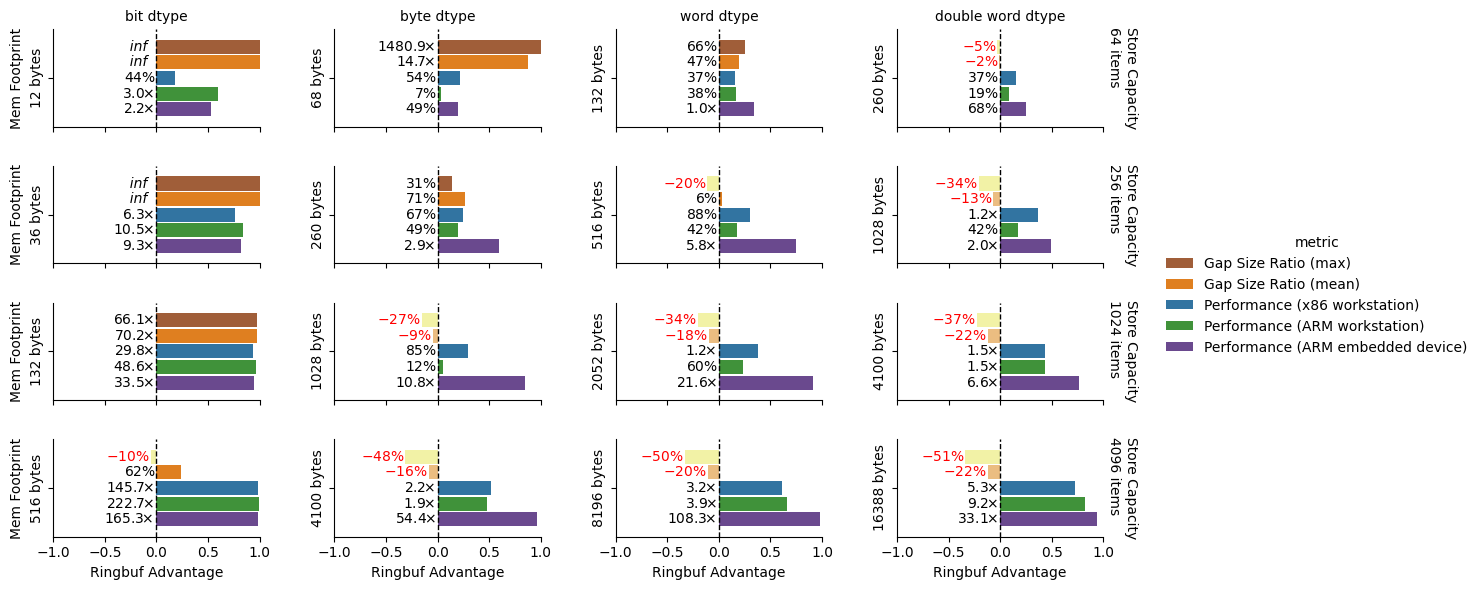

teeplots/2025-07-19-mem-perf-tilted/col=data-type+font.family=serif+hue=metric+kind=bar+lut=False+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.pdf
teeplots/2025-07-19-mem-perf-tilted/col=data-type+font.family=serif+hue=metric+kind=bar+lut=False+orient=h+qosnumitems=10000+row=num-sites+viz=catplot+x=advantage+y=tilted-memory-bytes+ext=.png


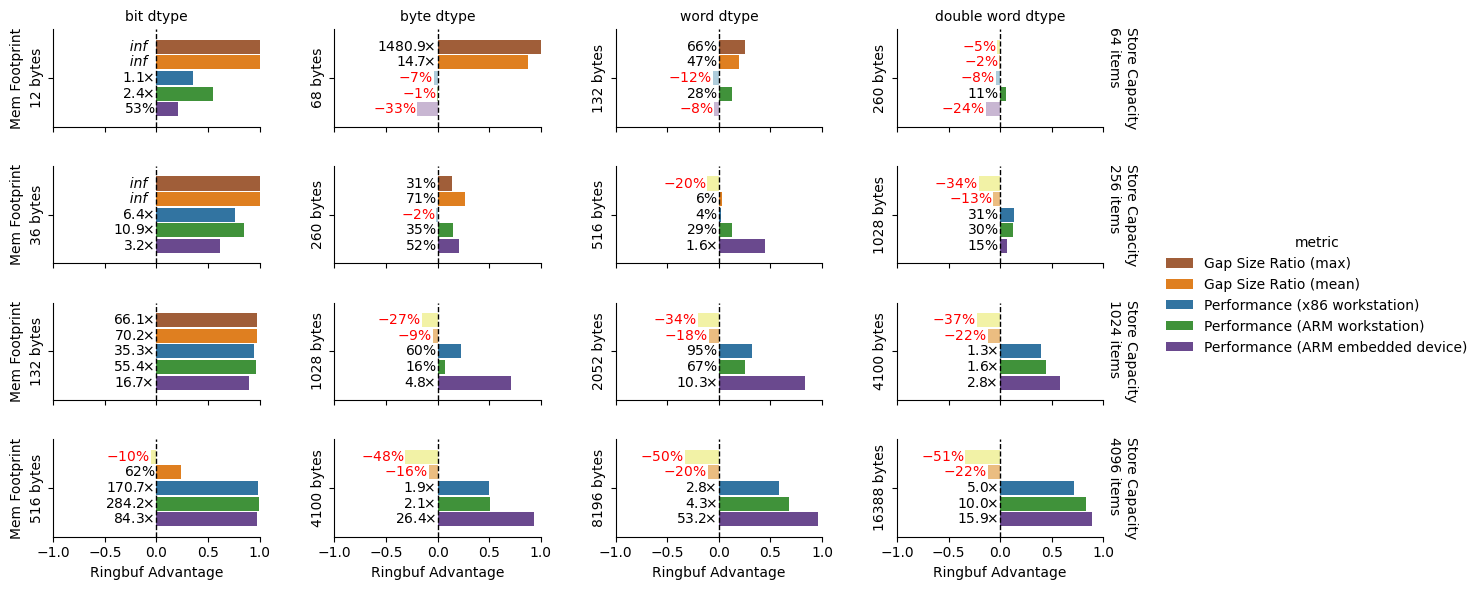

In [17]:
metrics = {
    "Gap Size Cost": "Gap Size Ratio (max)",
    "Gap Size Cost Mean": "Gap Size Ratio (mean)",
    "duration_s (x86 Intel Core Ultra 7 155U)": "Performance (x86 workstation)",
    "duration_s (ARM Apple M1)": "Performance (ARM workstation)",
    "duration_s (ARM Cortex-M0+)": "Performance (ARM embedded device)",
}
dark_palette = [
    # "#e31a1c",
    "#b15928",
    "#ff7f00",
    "#1f78b4",
    "#33a02c",
    "#6a3d9a",
]
light_palette = [
    # "#fb9a99",
    "#ffff99",
    "#fdbf6f",
    "#a6cee3",
    "#b2df8a",
    "#cab2d6",
]


for rc, lut in it.product([{}, {"font.family": "serif"}], [True, False]):
    perf_long_df = get_df_perf_long(
        ["dstream.tilted_algo", "dstream_tilted_algo"][lut]
    )
    long_df = pl.concat(
        [
            qos_long_df,
            perf_long_df,
        ],
        how="diagonal",
    ).with_columns(
        pl.col("metric").replace_strict(metrics),
        advantage=pl.col("symetricized") / 100,
    )
    col_order = ["bit", "byte", "word", "double word"]
    hue_order = [*metrics.values()]
    row_order = sorted(long_df["num_sites"].unique().to_list())
    kwargs = dict(
        x="advantage",
        y="tilted_memory_bytes",
        hue="metric",
        hue_order=hue_order,
        gap=0.1,
        orient="h",
    )

    with tp.teed(
        sns.catplot,
        data=long_df.with_columns(
            pl.col("advantage").clip(lower_bound=0),
        ).to_pandas(),
        col="data_type",
        row="num_sites",
        col_order=col_order,
        row_order=row_order,
        **kwargs,
        aspect=2,
        height=1.5,
        kind="bar",
        margin_titles=True,
        palette=dark_palette,
        sharex=True,
        sharey=False,
        teeplot_outattrs={
            "lut": lut,
            "qosnumitems": qos_num_items,
            **rc,
        },
        teeplot_subdir=teeplot_subdir,
    ) as g:
        for (row, col), ax in zip(
            it.product(row_order, col_order),
            g.axes.flat,
        ):
            for hue, bar in zip(
                hue_order,
                ax.patches,
            ):
                hue_df = long_df.filter(
                    pl.col("data_type") == col,
                    pl.col("num_sites") == row,
                    pl.col("metric") == hue,
                )
                label_val = hue_df["percent"].item() / 100

                xpos = min(hue_df["advantage"].item(), 0.0)
                ax.text(
                    x=xpos,
                    y=(
                        bar.get_y()
                        + bar.get_height() / 2
                    ),
                    s=(
                        f"  {label_val}  "
                        if not np.isfinite(label_val)
                        else fr"${label_val:.1f}\!\!\times\!$ "
                        if label_val >= 1
                        else fr"${label_val * 100:.0f}\%$ "
                    ),
                    ha="right",
                    va="center",
                    color=["red", "black"][label_val >= 0],
                    style="italic",
                )

            sns.barplot(
                data=long_df.with_columns(
                    pl.col("advantage").clip(upper_bound=0),
                ).filter(
                    pl.col("data_type") == col,
                    pl.col("num_sites") == row,
                ).to_pandas(),
                ax=ax,
                legend=False,
                **kwargs,
                palette=light_palette,
            )

        g.set(
            xlim=(-1, 1),
            xlabel="Ringbuf Advantage",
            ylabel="Mem Footprint",
        )
        g.set_titles(
            col_template="{col_name} dtype",
            row_template="Store Capacity\n{row_name} items",
        )

        for ax in g.axes.flat:
            ax.axvline(
                x=0.0,
                color="black",
                linestyle="--",
                linewidth=1,
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                ax.set_yticklabels(
                    [
                        f"{lbl.get_text()} bytes"
                        for lbl in ax.get_yticklabels()
                    ],
                )
            for lbl in ax.get_yticklabels():
                lbl.set_rotation(90)
                lbl.set_ha("right")
                lbl.set_va("center")

        for ax in g.axes[:, 1:].flat:
            ax.set_ylabel(None)
